## Tr的含义

calib.txt中的Tr表示 $T_{Velo->Camera}$，这里默认的坐标系可以是world，也可以是Velo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 配置路径 ---
base_path = '../data/07/'  # 假设 notebook 在 notebooks 文件夹下

# ==========================================
# 1. 解析 Calibration (核心任务)
# ==========================================

# 读取 calib.txt 中的全部矩阵
def read_calib(file_path):
    """
    读取KITTI calib文件，返回字典。
    重点关注 Tr: Velodyne -> Camera 变换矩阵
    """
    calib_data = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ':' in line:
                key, value = line.split(':', 1)
                calib_data[key] = np.array([float(x) for x in value.split()])
    return calib_data

calib = read_calib(base_path + 'calib.txt')

# 将 calib 的全部矩阵中的 Tr 矩阵重塑为齐次矩阵 (3x4 -> 4x4)
Tr_velo_to_cam = np.zeros((4, 4))
Tr_velo_to_cam[:3, :4] = calib['Tr'].reshape(3, 4)
Tr_velo_to_cam[3, 3] = 1.0

print(f"--- Tr (Velodyne to Camera) ---\n{Tr_velo_to_cam}")

# --- 分析 Tr 矩阵的物理含义 ---
# KITTI 定义: Camera (Z前, Y下, X右), Velodyne (X前, Y左, Z上) [cite: 26]
# V (0, 0, 1)

# 理论上, Velo的 X(前) 应该对应 Cam的 Z(前)
# 让我们看看矩阵的第一列 (对应 Velo x), 第二列 (对应 Velo y)...

print("\n--- 坐标轴映射分析 ---")
print(f"Velo X轴 (1,0,0) 变换后 -> {Tr_velo_to_cam[:3, 0]} (接近 Camera Z轴 [0,0,1]?)")
print(f"Velo Y轴 (0,1,0) 变换后 -> {Tr_velo_to_cam[:3, 1]} (接近 Camera X轴 [-1,0,0]?)") # 注意由左手/右手系导致的负号
print(f"Velo Z轴 (0,0,1) 变换后 -> {Tr_velo_to_cam[:3, 2]} (接近 Camera Y轴 [0,-1,0]?)")



## Tr矩阵的理解

依据基的关系求取$T_{Velo->Camera}$

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 0. 基础设置 ---
base_path = '../data/07/'  # 请确保路径正确

# ==========================================
# 1. 旋转矩阵的理论与实战对比
# ==========================================
# Velo -> Camera 的变换，只需要找到 Velo 系的基在 Camera 系下的向量表示
# 例如，根据 Velodyne (X前, Y左, Z上)  Camera (Z前, Y下, X右) 画图发现
# Velodyne (1, 0, 0)T --> Camera (0, 0, 1)T
# Velodyne (0, 1, 0)T --> Camera (-1, 0, 0)T
# Velodyne (0, 0, 1)T --> Camera (0, -1, 0)T
# 得到 Velodyne --> Camera的矩阵为


# --- A. 你推导的理论矩阵 ---
# 你的推导完全正确：
# Velo X(前) -> Cam Z(前)  => [0, 0, 1]
# Velo Y(左) -> Cam X(左/负右) => [-1, 0, 0]
# Velo Z(上) -> Cam Y(上/负下) => [0, -1, 0]
vx = np.array([0, 0, 1.0])
vy = np.array([-1.0, 0, 0])
vz = np.array([0, -1.0, 0])

# 这是一个旋转矩阵 R_velo_to_cam (从 Velo 映射到 Cam)
R_theory = np.column_stack([vx, vy, vz])

print("【理论推导】你计算的旋转矩阵 R (Velo -> Cam):")
print(R_theory)

# --- B. 数据集提供的 Tr 矩阵 ---
# 读取 Calib 文件
def read_calib_simple(file_path):
    with open(file_path, 'r') as f:
        for line in f:
            if 'Tr:' in line:
                return np.array([float(x) for x in line.split(':')[1].split()]).reshape(3, 4)
    return None

Tr_matrix = read_calib_simple(base_path + 'calib.txt')
R_data = Tr_matrix[:3, :3] # 取前 3x3 旋转部分

print("\n【实际数据】KITTI 提供的 Tr 矩阵旋转部分:")
print(np.round(R_data, 4)) # 保留4位小数方便对比

print("\n【结论】两者非常接近！说明你的理论推导是正确的，可以直接用 R_data 进行高精度转换。")

【理论推导】你计算的旋转矩阵 R (Velo -> Cam):
[[ 0. -1.  0.]
 [ 0.  0. -1.]
 [ 1.  0.  0.]]

【实际数据】KITTI 提供的 Tr 矩阵旋转部分:
[[-0.0019 -1.     -0.008 ]
 [-0.0065  0.0081 -0.9999]
 [ 1.     -0.0018 -0.0065]]

【结论】两者非常接近！说明你的理论推导是正确的，可以直接用 R_data 进行高精度转换。


## 坐标系变换说明

当前轨迹点为：

$$
\mathbf{p}_{cam}
$$
（点在 Camera 坐标系中的坐标）

已知（来自 `calib.txt`）的变换关系：

$$
\mathbf{p}_{cam}
=
R_{velo\rightarrow cam}\; \mathbf{p}_{velo}
+
\mathbf{t}_{velo\rightarrow cam}
$$

其中：

- $R_{velo\rightarrow cam}$：**从 Velodyne 系到 Camera 系的旋转矩阵**
- $\mathbf{t}_{velo\rightarrow cam}$：Velodyne 原点在 Camera 系下的平移向量

**记法规则（源 $\to$ 目标）：**
> 右下角的 `velo→cam` 明确表示：输入是 Velodyne 系坐标，输出是 Camera 系坐标。

---

### 忽略平移项（为了看轨迹形状）

忽略平移 $\mathbf{t}$，仅考虑旋转：

$$
\mathbf{p}_{cam}
\approx
R_{velo\rightarrow cam}\; \mathbf{p}_{velo}
$$

反解 $\mathbf{p}_{velo}$（因为我们需要把原本在 Cam 系下的轨迹点，转回到 Velo 系下观察，或者反之）：

$$
\mathbf{p}_{velo}
=
\left(R_{velo\rightarrow cam}\right)^{-1}
\; \mathbf{p}_{cam}
$$

因为旋转矩阵是正交矩阵（$R^{-1} = R^T$）：

$$
\mathbf{p}_{velo}
=
\left(R_{velo\rightarrow cam}\right)^T
\; \mathbf{p}_{cam}
$$

也可以写作：

$$
\boxed{
\mathbf{p}_{velo}
=
R_{cam\rightarrow velo}
\; \mathbf{p}_{cam}
}
$$

---

### 变换矩阵记法总结

为了避免歧义，我们遵循**链式法则（Chain Rule）**：

$$
\mathbf{p}_{B} = R_{A\rightarrow B} \; \mathbf{p}_{A}
$$

- **输入（右侧）**：$\mathbf{p}_{A}$ （在 A 系）
- **矩阵（中间）**：$R_{A\rightarrow B}$ （将 A 变换到 B）
- **输出（左侧）**：$\mathbf{p}_{B}$ （在 B 系）

在本例中：

1.  **原始标定参数**（Calib）：
    $$
    R_{velo\rightarrow cam}
    $$
    *(作用：把点从雷达系转到相机系)*

2.  **需要的逆变换**：
    $$
    R_{cam\rightarrow velo} = (R_{velo\rightarrow cam})^T
    $$
    *(作用：把点从相机系转回雷达系)*

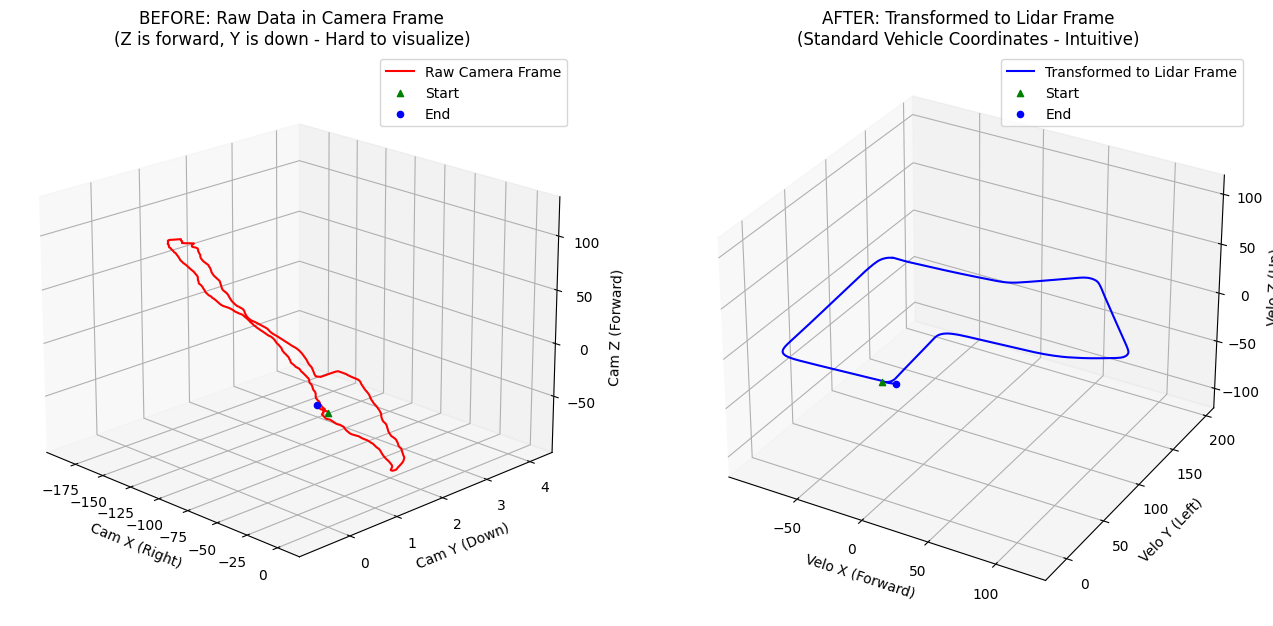

In [26]:
# ==========================================
# 2. 轨迹坐标转换 (核心步骤)
# ==========================================
# 读取位姿
poses = np.loadtxt(base_path + 'poses/orig_poses.txt')
# 提取平移量 (N, 3)，此时是 Camera 坐标系 (x=右, y=下, z=前)
traj_cam = poses[:, [3, 7, 11]] 

# --- 换系操作 ---
# 我们想把 Camera 系的点，转回符合人类直觉的 Velodyne 系 (x=前, y=左, z=上)
# 公式: P_cam = R * P_velo  ==>  P_velo = R.T * P_cam
# 在代码中，因为 traj_cam 是 (N, 3) 的行向量矩阵，矩阵乘法写为:
# P_velo = P_cam @ R  (这等价于 P_velo.T = R.T @ P_cam.T)
# 这里的 R 就是 R_velo_to_cam (即 R_data)

traj_velo = traj_cam @ R_data

# ==========================================
# 3. 对比可视化
# ==========================================
fig = plt.figure(figsize=(16, 8))

# --- 左图：原始 Camera 坐标系数据 ---
ax1 = fig.add_subplot(121, projection='3d')
# 注意：直接画原始 x,y,z，不手动调整轴，看看有多反直觉
ax1.plot(traj_cam[:, 0], traj_cam[:, 1], traj_cam[:, 2], label='Raw Camera Frame', color='red')
# 标出起点和终点
ax1.scatter(traj_cam[0,0], traj_cam[0,1], traj_cam[0,2], c='g', marker='^', label='Start')
ax1.scatter(traj_cam[-1,0], traj_cam[-1,1], traj_cam[-1,2], c='b', marker='o', label='End')

ax1.set_xlabel('Cam X (Right)')
ax1.set_ylabel('Cam Y (Down)')
ax1.set_zlabel('Cam Z (Forward)')
ax1.set_title('BEFORE: Raw Data in Camera Frame\n(Z is forward, Y is down - Hard to visualize)')
ax1.legend()
ax1.view_init(elev=20, azim=-45) # 调整个视角

# --- 右图：转换后的 Velodyne 坐标系数据 ---
ax2 = fig.add_subplot(122, projection='3d')
# 画转换后的数据
ax2.plot(traj_velo[:, 0], traj_velo[:, 1], traj_velo[:, 2], label='Transformed to Lidar Frame', color='blue')
# 标出起点和终点
ax2.scatter(traj_velo[0,0], traj_velo[0,1], traj_velo[0,2], c='g', marker='^', label='Start')
ax2.scatter(traj_velo[-1,0], traj_velo[-1,1], traj_velo[-1,2], c='b', marker='o', label='End')

ax2.set_xlabel('Velo X (Forward)')
ax2.set_ylabel('Velo Y (Left)')
ax2.set_zlabel('Velo Z (Up)')
ax2.set_title('AFTER: Transformed to Lidar Frame\n(Standard Vehicle Coordinates - Intuitive)')
ax2.legend()

# 强制等比例显示 (简单的包围盒法)
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)
    plot_radius = 0.5*max([x_range, y_range, z_range])
    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

set_axes_equal(ax2) # 只对右图做等比例，让轨迹看起来不扁
plt.show()